## Basic modeling with the TRCRP Mixture

This tutorial notebook shows the basic interface for creating a TRCRP mixture model for four time series, running inference to fit the model, and simulating values for imputation and forecasting.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
rng = np.random.RandomState(1)

### Loading and plotting the time series dataset

In [4]:
frame = pd.read_csv('resources/ggToyMissing.csv', index_col=0)

Each column in `frame` is a time series variable, and `frame.index` contains the integer-valued timepoints at which the time series were observed. Values in the index need not be contiguous, so long as they are integer-valued.

In [5]:
frame.head()

,a,b,c,d
0,-0.179312,-0.292974,2.792519,1.869283
1,-0.414784,-0.391834,1.734128,1.472738
2,-0.483769,-0.436033,0.627319,0.960280
3,-0.459103,-0.573395,0.257649,0.819960
4,-0.489040,-0.521472,-0.019140,-0.239753


This dataset has missing values for variables `a` and `d`, which are encoded as `float(nan)`. For example, `a` is not observed at time points 100, 101, 102, 103, 104, ....

In [6]:
frame[pd.isnull(frame['a'])].head()

,a,b,c,d
100,NaN,-0.581752,0.019613,-0.781691
101,NaN,-0.564875,0.062787,-0.377687
102,NaN,-0.545189,0.987036,-0.457000
103,NaN,-0.606666,-0.251298,-0.035626
104,NaN,-0.597310,-0.531743,-0.623570


... and `d` is not observed at time points 20, 21, 2, 23, 24.

In [7]:
frame[pd.isnull(frame['d'])].head()

,a,b,c,d
20,-0.993966,-1.107563,-7.369576,NaN
21,-1.026810,-1.070512,-6.538912,NaN
22,-1.069871,-1.040572,-6.875310,NaN
23,-1.049251,-1.100071,-6.345228,NaN
24,-0.999196,-1.040606,-5.762845,NaN


We can also plot the time series.

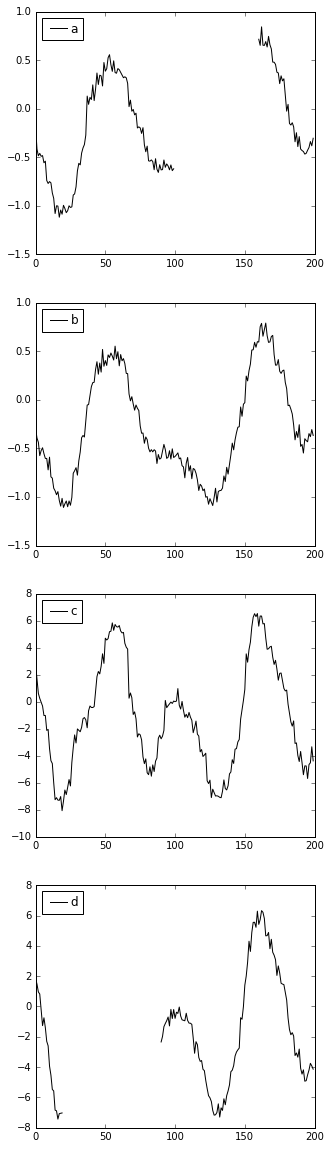

In [8]:
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, frame.columns):
    index = list(frame.columns).index(variable)
    x_observed = frame.index
    y_observed = frame.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.legend(loc='upper left', handletextpad=0)
fig.set_size_inches(5,20)

### Creating a TRCRP mixture model and incorporating the data

We now create a TRCRP mixture model for the time series. The `chains` parameter specifies the number of MCMC chains to use for inference; `lag` is a parameter specifying the window-length for the model (intuitively, we can think of this parameter as playing a similar role to that of the order $p$ in an AR(p) model); `variables` is a list of names of the time series taken from the columns of the data frame; and `rng` is the source of randomness.

In [9]:
from trcrpm import TRCRP_Mixture
model = TRCRP_Mixture(chains=4, lag=10, variables=frame.columns, rng=rng)

We now incorporate the observations into the model. New observations can be continuously incorporated into the model.

In [10]:
model.incorporate(frame)

### Running MCMC inference to learn the latent parameters 

Inference in the TRCRPM is based on Markov Chain Monte Carlo (MCMC) and Sequential Monte Carlo (SMC). In this tutorial we focus on MCMC. The `resample_all` method cycles through all inference kernels, and resamples latent parameters from the approximate posterior using Gibbs. The method accepts either a `seconds` or `steps` parameter, below we choose to run for 20 seconds. A report showing the number of MCMC iterations completed by each of the four chains is printed.

In [11]:
model.resample_all(seconds=20)

Completed: 114 iterations in 20.013755 seconds.
Completed: 112 iterations in 20.018023 seconds.
Completed: 71 iterations in 20.011768 seconds.
Completed: 123 iterations in 20.047407 seconds.


After cycling through the inference kernels, it is often a good idea to tune the model's hyperparameters, using the `resample_hyperparameters` method. These hyperparameters are tuned using empirical Bayes; namely we use dataset-dependent heuristics to construct a gridded Gibbs sampler whose grid points are logarithmically spaced (forming a discrete approximation of an exponential prior).

In [12]:
model.resample_hyperparameters(seconds=10)

Completed: 12 iterations in 10.050288 seconds.
Completed: 14 iterations in 10.064912 seconds.
Completed: 8 iterations in 10.073672 seconds.
Completed: 15 iterations in 10.478348 seconds.


### Simulating new data

Recall that time series `a` and `d` both had missing data. We can simulate new values for both observed and unobserved data using the `simulate` method. This method takes in a list of probe points (integer-valued timepoints at which to query the model), a list of variable names (the time series to simulate), and an integer number of samples to generate from each chain in the model.

In [13]:
probes = model.dataset.index
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

Some plotting methods...

In [14]:
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [15]:
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    ax.set_ylim([min(y_observed)-2, max(y_observed)+2])
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

Now let's plot the model's predictions. Observed data are shown in black, and the interquartile range (25th percentile to 75th percentile) of posterior samples at each probed timepoint are shown in gray. Note how the model interpolates missing data for time series `a` and `d`, by sharing strength from time series `b` and `d`, respectively.

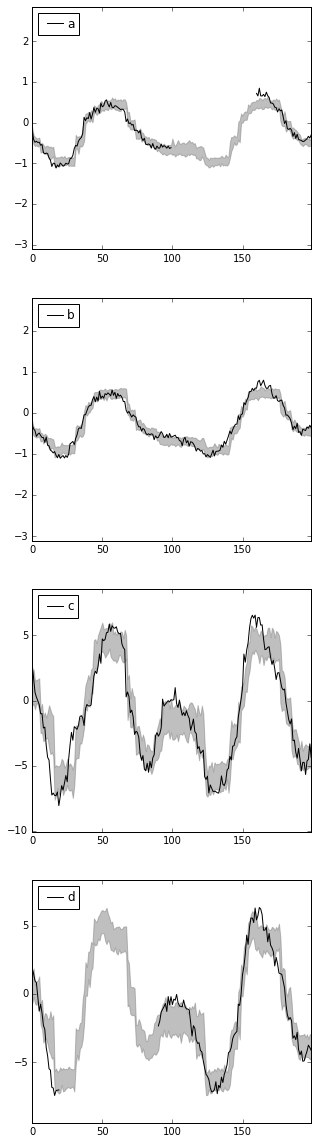

In [16]:
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(probes), max(probes)])
fig.set_size_inches(5,20)

### Viewing the latent state sequence at each timepoint

The TRCRP Mixture posits that, at each time point $t$, there is a discrete-valued latent state $z_t$ which governs the distribution of observation $x_t$. The intuition is similar to that of a standard hidden Markov model (HMM), even though the TRCRP Mixture is not Markovian since the latent state variables $z_t$ are coupled into the infinite past.

Each chain in the model contains a different posterior sample of the latent states $\lbrace z_t \rbrace$. We can gain an intuition for how the model shares strength across time series by plotting the latent state sequence learned by a particular chain in the model. The method `get_temporal_regimes` takes in a variable name (and an optional set of observed timepoints) and returns a list of the $z_t$ (see `plot_latent_state_sequence` above) at those timepoints. Below, we'll plot the latent states from chain 0. What do you notice about how the distribution of the data differs according to the colored segment?

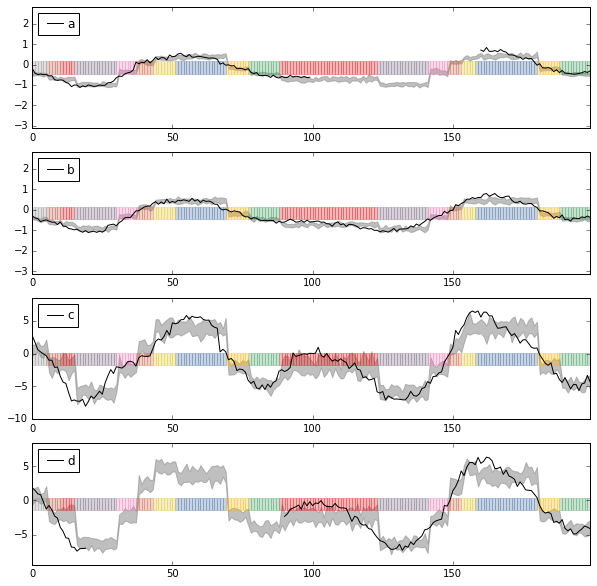

In [17]:
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]

fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples_chain, variable, ax, states_from_chain=chain)
    ax.set_xlim([min(probes), max(probes)])
fig.set_size_inches(10,10)

### Extrapolating the time series

The TRCRP mixture is a purely empirical model which does not contain any time series-specific parametric assumptions, such as seasonality, trends, or time-varying functions. Instead, the model uses (multivariate) patterns from past observations to predict the present and future.

Recall that we initialized the model with a `window=10` parameter. Heurisitically, we can think of the model as formulating predictions as follows: at time $t$, it obtains the previous values in the current window (i.e. the previous 10 values), and searches the history of the time series to find points in time $t' < t$ where the window of $x_{t'}$ is "similar" to the current window $x_{t}$. The intuition is that if two points $(t,t')$ have similar window values in their short-term history, then they are likely to have similar observation values $(x_t, x_{t'})$.

This inductive bias has implications for the model's behavior when extrapolating time series into the future. In the absence of (i) parametric assumptions, and (ii) signal from the windowed history, the model's predictions will quickly return to the prior with wide confidence bands. In the cell below, we generate data 100 timesteps into the future. Notice how the error bars gradually become wider after 200 to 210 (i.e. 10 steps, the window size).

In [18]:
probes = list(model.dataset.index) + range(max(model.dataset.index), max(model.dataset.index)+100)
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

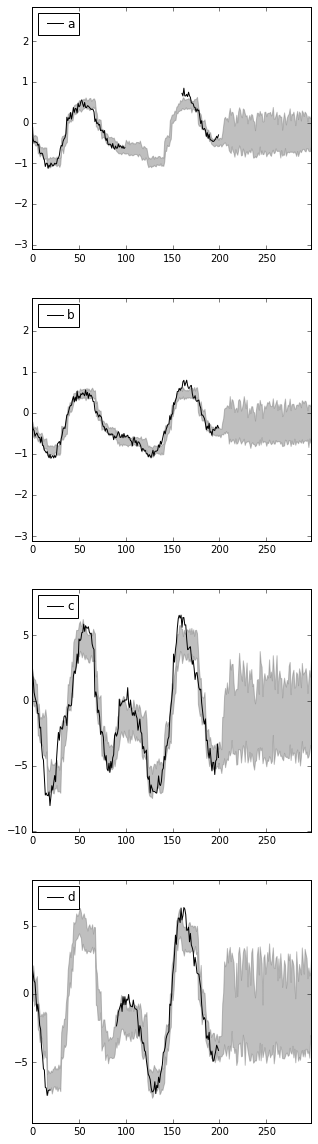

In [19]:
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(probes), max(probes)])
fig.set_size_inches(5, 20)

In a future tutorial, we will explore datasets where (unlike this dataset) the windowed history contains significant signal, leading the TRCRP mixture to produce very accurate and sharp forecasts.